# Welcome to PointNet& 3D CNNs Workshop!
In this workshop, we're going to learn how to voxelize a point cloud, and build a 3D Convolutional Neural Network to classify point clouds. When processing point clouds, voxel based approaches account for a good half of the existing approaches (with point based approaches being the second half) — and it's therefore important to understand how to implement them!

## Imports

In [1]:
try:
    import nbformat
    import IPython
    def _ver_tuple(ver):
        parts = ver.split(".")
        nums = []
        for part in parts:
            try:
                nums.append(int(part))
            except ValueError:
                break
        return tuple(nums)
    if _ver_tuple(nbformat.__version__) < (4, 2, 0):
        print(f"nbformat {nbformat.__version__} is too old; please upgrade nbformat>=4.2.0")
    else:
        print(f"nbformat {nbformat.__version__} OK")
except Exception as exc:
    print("Missing nbformat or IPython; install dependencies from requirements.txt.")
    print(exc)


nbformat 5.10.4 OK


In [2]:
# Usual Imports
import os
import sys
import json
import numpy as np
from tqdm import tqdm

# plotting library
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# append path to custom scripts
UTILS_PATH = os.path.join('lidar-od-scripts', 'gpuVersion', 'gpuVersion')
sys.path.append(UTILS_PATH)

# DL Imports
import torch
import torch.nn as nn

# custom imports
#from visual_utils import plot_pc_data3d, plot_bboxes_3d
try:
    from visual_utils import plot_pc_data3d, plot_bboxes_3d
except Exception:
    def plot_pc_data3d(x, y, z, apply_color_gradient=False, color=None, marker_size=2):
        return [go.Scatter3d(x=x, y=y, z=z, mode="markers", marker=dict(size=marker_size, color=color))]
    def plot_bboxes_3d(*args, **kwargs):
        return []


In [3]:
PROJECT_ROOT = os.path.abspath(".")
DATA_ROOT = os.path.join(PROJECT_ROOT, "subset")
print("DATA_ROOT:", os.path.abspath(DATA_ROOT))
assert os.path.isdir(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"
DATA_FOLDER = DATA_ROOT

class_name_id_map = {
    'Airplane': 0,
    'Chair': 1,
    'Table': 2,
    'Lamp': 3,
    'Car': 4,
    'Mug': 5,
}

class_id_name_map = {v: k for k, v in class_name_id_map.items()}

PCD_SCENE=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data')
device = torch.device("cpu")
EPOCHS = 25


## Shapenet Core Dataset exploration

- Object Classification and part Segmentation Dataset from Point Cloud data
- [Shapenet core](https://shapenet.org/) is a subset of the full ShapeNet dataset 
- It contains single clean 3D models, manually verified category and alignment annotations. 
- 16 classes from 12 categories

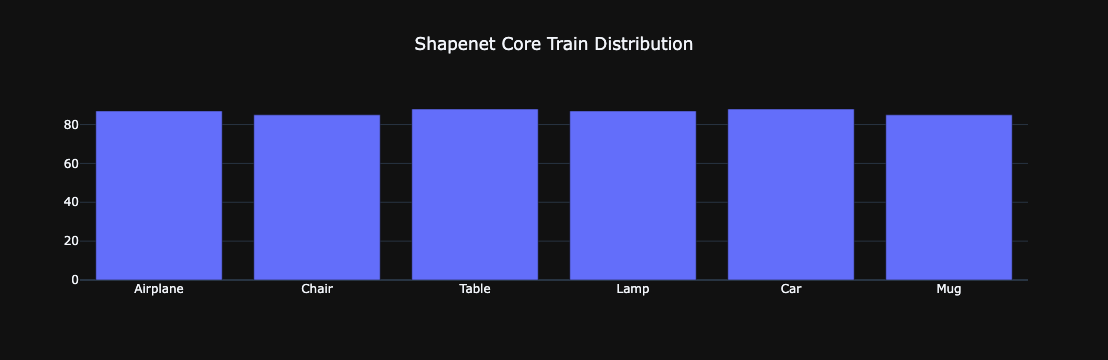

In [4]:
train_split_data = json.load(open(os.path.join(DATA_FOLDER, 'train_split.json'), 'r'))
train_class_count = np.array([x[0] for x in train_split_data])

# plot classwise count in train set
train_dist_plots = [go.Bar(x=list(class_name_id_map.keys()), y= np.bincount(train_class_count))]
layout = dict(template="plotly_dark", title="Shapenet Core Train Distribution", title_x=0.5)
fig = go.Figure(data=train_dist_plots, layout=layout)   
fig.show()


In [5]:
import random

def gather_points_files(root):
    exts = [".npy", ".npz", ".pts", ".txt"]
    files_by_ext = {ext: [] for ext in exts}
    for dirpath, _, filenames in os.walk(root):
        for filename in filenames:
            if filename.startswith("."):
                continue
            ext = os.path.splitext(filename)[1].lower()
            if ext in files_by_ext:
                files_by_ext[ext].append(os.path.join(dirpath, filename))
    for ext in exts:
        if files_by_ext[ext]:
            return sorted(files_by_ext[ext]), ext
    return [], None

points_list, points_ext = gather_points_files(DATA_FOLDER)
print("Found points files:", len(points_list))
print("Example:", points_list[:3])
if len(points_list) == 0:
    raise RuntimeError("points_list is empty. Check DATA_ROOT and run make_subset.py.")


0


In [6]:
idx = random.randrange(len(points_list))
points_path = points_list[idx]
if points_ext == ".npy":
    points = np.load(points_path)
elif points_ext == ".npz":
    data = np.load(points_path)
    if "points" in data:
        points = data["points"]
    else:
        points = data[list(data.keys())[0]]
else:
    points = np.loadtxt(points_path)

print(f"points shape = {points.shape}, min xyz = {np.min(points, axis=0)}, max xyz = {np.max(points, axis=0)}")

seg_file_path = points_path.replace(f"{os.sep}points{os.sep}", f"{os.sep}points_label{os.sep}")
seg_file_path = os.path.splitext(seg_file_path)[0] + ".seg"
if not os.path.exists(seg_file_path):
    alt_path = os.path.splitext(seg_file_path)[0] + ".txt"
    seg_file_path = alt_path if os.path.exists(alt_path) else seg_file_path
if os.path.exists(seg_file_path):
    seg_labels = np.loadtxt(seg_file_path).astype(np.int8)
    print(f"seg_labels shape = {seg_labels.shape}, unique labels = {np.unique(seg_labels)}")
else:
    print(f"No seg labels found for {points_path}")


IndexError: list index out of range

In [ ]:
# there are max of 16 parts in an object in Shapenet core dataset
# creating random colors in according to part label
NUM_PARTS = 16
PART_COLORS = np.random.choice(range(255),size=(NUM_PARTS,3))

In [ ]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

## Build a Custom Dataset
Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

### Subset workflow (CPU-friendly)

This notebook expects a pre-built subset in `PointNet/subset/` (see `make_subset.py`).
Run it before training to keep runtime reasonable.


In [ ]:
assert os.path.exists(os.path.join(DATA_FOLDER, 'train_split.json'))
assert os.path.exists(os.path.join(DATA_FOLDER, 'val_split.json'))
assert os.path.exists(os.path.join(DATA_FOLDER, 'test_split.json'))


In [ ]:
class ShapeNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split_type, num_samples=2500):
        self.root_dir = root_dir
        self.split_type = split_type
        self.num_samples = num_samples
        with open(os.path.join(root_dir, f'{self.split_type}_split.json'), 'r') as f:
            self.split_data = json.load(f)       
            
    def __getitem__(self, index):
        # read point cloud data
        class_id, class_name, point_cloud_path, seg_label_path = self.split_data[index]
        
        # point cloud data
        point_cloud_path = os.path.join(self.root_dir, point_cloud_path)
        pc_data = np.load(point_cloud_path)
        
        # segmentation labels
        # -1 is to change part values from [1-16] to [0-15]
        # which helps when running segmentation
        pc_seg_labels = np.loadtxt(os.path.join(self.root_dir, seg_label_path)).astype(np.int8) - 1
#         pc_seg_labels = pc_seg_labels.reshape(pc_seg_labels.size,1)
        
        # Sample fixed number of points
        num_points = pc_data.shape[0]
        if num_points < self.num_samples:
            # Duplicate random points if the number of points is less than max_num_points
            additional_indices = np.random.choice(num_points, self.num_samples - num_points, replace=True)
            pc_data = np.concatenate((pc_data, pc_data[additional_indices]), axis=0)
            pc_seg_labels = np.concatenate((pc_seg_labels, pc_seg_labels[additional_indices]), axis=0)
                
        else:
            # Randomly sample max_num_points from the available points
            random_indices = np.random.choice(num_points, self.num_samples)
            pc_data = pc_data[random_indices]
            pc_seg_labels = pc_seg_labels[random_indices]
        
        # return variable
        data_dict= {}
        data_dict['class_id'] = class_id
        data_dict['class_name'] = class_name        
        data_dict['points'] = pc_data 
        data_dict['seg_labels'] = pc_seg_labels 
        return data_dict        
                    
    def __len__(self):
        return len(self.split_data)

In [ ]:
train_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='train')
val_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='val')
test_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='test')
print(f"Train set length = {len(train_set)}")
print(f"Validation set length = {len(val_set)}")
print(f"Test set length = {len(test_set)}")

In [ ]:
def split_counts(dataset):
    counts = {}
    for entry in dataset.split_data:
        class_id = entry[0]
        counts[class_id] = counts.get(class_id, 0) + 1
    return counts

print("Train counts:", split_counts(train_set))
print("Val counts:", split_counts(val_set))
print("Test counts:", split_counts(test_set))
all_ids = [e[0] for e in train_set.split_data + val_set.split_data + test_set.split_data]
print("Class id range:", min(all_ids), max(all_ids))
assert min(all_ids) >= 0 and max(all_ids) <= 5, "Class ids should be in [0,5] for subset"


In [ ]:
data_dict= train_set[25]
print(f"Keys in dataset sample = {list(data_dict.keys())}")
points = data_dict['points']
seg_labels = data_dict['seg_labels']
print(f"class_id = {data_dict['class_id']}, class_name = {data_dict['class_name']}")

In [ ]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title=f"{data_dict['class_name']}, class id = {data_dict['class_id']}, from Shapenetcore Torch Dataset", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

### Data loader for Custom dataset

In [ ]:
def collate_fn(batch_list):
    ret = {}
    ret['class_id'] =  torch.from_numpy(np.array([x['class_id'] for x in batch_list])).long()
    ret['class_name'] = np.array([x['class_name'] for x in batch_list])
    ret['points'] = torch.from_numpy(np.stack([x['points'] for x in batch_list], axis=0)).float()
    ret['seg_labels'] = torch.from_numpy(np.stack([x['seg_labels'] for x in batch_list], axis=0)).long()
    return ret

In [ ]:
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=2, shuffle=True, collate_fn=collate_fn) 
dataloader_iter = iter(sample_loader)   
batch_dict = next(dataloader_iter)
print(batch_dict.keys())
for key in ['points','seg_labels', 'class_id']:
    print(f"batch_dict[{key}].shape = {batch_dict[key].shape}")

In [ ]:
batchSize= 64
workers = 2
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchSize,shuffle=True, num_workers=workers, collate_fn=collate_fn)

# PointNet

**The model is PointNet.**<p>
![PointNet](https://d3i71xaburhd42.cloudfront.net/c3b6a072288e134f5ae6afe3eebc970ffb65cb68/3-Figure2-1.png)

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

The Point-Net will be done in several parts:
* T-Net
* FeatureNet
* Classification or Segmentation Head

### T-Net

In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

class STN3d(nn.Module):
    """
    T-Net Model.
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        
        self.mp1 = torch.nn.MaxPool1d(num_points)
        
        # FC layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        
        # Expected input shape = (bs, 3, num_points)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [ ]:
test_model = STN3d().to(device)
sim_data = Variable(torch.rand(32,3,2500)).to(device)
out = test_model(sim_data)
print('stn', out.size())

## FeatureNet

In [ ]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat

    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [ ]:
pointfeat = PointNetfeat(global_feat=True).to(device)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False).to(device)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

## Classifier Head

In [ ]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1), trans

In [ ]:
cls = PointNetCls(k = 16).to(device)
out, _ = cls(sim_data)
print('class', out.size())

## Training

In [ ]:
def train_model(model, num_epochs, criterion, optimizer, dataloader_train,
                label_str = 'class_id', lr_scheduler = None, output_name = 'pointnet.pth'):
    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for batch_dict in tqdm(dataloader_train, total=len(dataloader_train)):            
            # Forward pass
            x = batch_dict['points'].transpose(1, 2).to(device)
            labels = batch_dict[label_str].to(device)
            pred, _ = model(x)
            loss = criterion(pred, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}')
    torch.save(model.state_dict(), output_name)

In [ ]:
import torch.optim as optim

N_EPOCHS = EPOCHS
num_points = 2500
num_classes = 16
criterion = nn.NLLLoss()

# create model, optimizer, lr_scheduler and pass to training function
num_classes = len(class_id_name_map.items())
classifier = PointNetCls(k = num_classes, num_points = num_points)

# DEFINE OPTIMIZERS
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
_ = train_model(classifier, N_EPOCHS, criterion, optimizer, train_loader)


## Inference

In [ ]:
classifier = PointNetCls(k=num_classes).to(device) 
classifier.load_state_dict(torch.load('pointnet.pth'))
classifier.eval()

total_loss = 0.0

with torch.no_grad():
    for batch_dict in tqdm(test_loader, total=len(test_loader)):
        x = batch_dict['points'].transpose(1, 2).to(device)
        labels = batch_dict['class_id'].to(device)
        pred, _ = classifier(x)

        # calculate loss
        loss = criterion(pred, labels)
        total_loss += loss.item()

evaluation_loss = total_loss / len(test_loader)
print(evaluation_loss)

## Test on individual items

In [ ]:
# Random test sample
test_sample = test_set[np.random.choice(np.arange(len(test_set)))]
batch_dict = collate_fn([test_sample])
x = batch_dict['points'].transpose(1, 2).to(device)

# Get model predictions
model_preds, _ = classifier(x)
predicted_class = torch.argmax(model_preds, axis=1).detach().cpu().numpy()[0]
predicted_class_name = class_id_name_map[predicted_class]
pred_class_probs = F.softmax(model_preds.flatten(), dim=None).detach().cpu().numpy()

# plot results
title = f"Label = {test_sample['class_name']}, Predicted class = {predicted_class_name}"
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {}]], column_widths=[0.4, 0.6])
fig.update_layout(template="plotly_dark", scene=PCD_SCENE, height = 400, width = 1200,
                title=title, title_x=0.1, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))    
fig.add_trace(plot_pc_data3d(x=test_sample['points'][:,0], y=test_sample['points'][:,1], z=test_sample['points'][:,2]), row=1, col=1)
fig.add_trace(go.Bar(x=list(class_name_id_map.keys()), y=pred_class_probs, showlegend=False), row=1, col=2)
fig.show()

## Segmentation

In [ ]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x, trans

In [ ]:
seg = PointNetDenseCls(k = 16).to(device)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

## Training segmentation model

In [ ]:
N_EPOCHS = EPOCHS
num_points = 2500
criterion = nn.CrossEntropyLoss()

# create model, optimizer, lr_scheduler and pass to training function
num_classes = len(class_id_name_map.items())
dense_classifier = PointNetDenseCls(k = NUM_PARTS, num_points = num_points)
dense_classifier.to(device)

# DEFINE OPTIMIZERS
optimizer = optim.SGD(dense_classifier.parameters(), lr=0.01, momentum=0.9)

train_model(dense_classifier, N_EPOCHS, criterion, optimizer, train_loader, 
            label_str='seg_labels', output_name='pointnet_seg.pth')


## Inference

In [ ]:
dense_classifier.load_state_dict(torch.load('pointnet_seg.pth'))
dense_classifier.eval()

total_loss = 0.0

with torch.no_grad():
    for batch_dict in tqdm(test_loader, total=len(test_loader)):
        x = batch_dict['points'].transpose(1, 2).to(device)
        labels = batch_dict['seg_labels'].to(device)
        pred, _ = dense_classifier(x)

        # calculate loss
        loss = criterion(pred, labels)
        total_loss += loss.item()

evaluation_loss = total_loss / len(test_loader)
print(evaluation_loss)

## Test on individual items

In [ ]:
# Random test sample
test_sample = test_set[np.random.choice(np.arange(len(test_set)))]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
model_preds, _ = dense_classifier(x)
pred_part_labels = torch.argmax(model_preds, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']


# plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Part Predictions'))

# ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2)

# ground truth part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2)

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 400, width = 1200,
                title='PointNet Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
fig.show()

**Conclusion:** Dropping a coordinate or projecting after rotation reduces accuracy compared to the baseline,
showing that full 3D geometry is important for PointNet performance on this subset.


**Conclusion:** The modified classifier trades capacity for speed; accuracy changes are visible in the bar plot.
T-Net aligns shapes differently between models, but both preserve overall structure.


## Analysis Option 3.1 — Feature importance

We compare the baseline to two variants: (1) dropping one coordinate (set Z to 0),
and (2) random rotation followed by projection by zeroing a random axis.


In [ ]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_dict in dataloader:
            x = batch_dict['points'].transpose(1, 2).to(device)
            labels = batch_dict['class_id'].to(device)
            pred, _ = model(x)
            preds = torch.argmax(pred, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.numel()
    return correct / max(total, 1)

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, base, transform):
        self.base = base
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        data = self.base[idx]
        pts = data['points'].copy()
        data['points'] = self.transform(pts)
        return data

def drop_z(points):
    pts = points.copy()
    pts[:, 2] = 0.0
    return pts

class RandomProject:
    def __init__(self, seed=42):
        self.rng = np.random.RandomState(seed)
    def __call__(self, points):
        pts = points.copy()
        angle = self.rng.uniform(0, 2 * np.pi)
        axis = self.rng.choice([0, 1, 2])
        c, s = np.cos(angle), np.sin(angle)
        if axis == 0:
            R = np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
        elif axis == 1:
            R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
        else:
            R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        pts = pts @ R.T
        drop_axis = self.rng.choice([0, 1, 2])
        pts[:, drop_axis] = 0.0
        return pts

drop_train = TransformDataset(train_set, drop_z)
drop_val = TransformDataset(val_set, drop_z)
proj_train = TransformDataset(train_set, RandomProject(seed=123))
proj_val = TransformDataset(val_set, RandomProject(seed=456))

drop_loader = torch.utils.data.DataLoader(drop_train, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
drop_val_loader = torch.utils.data.DataLoader(drop_val, batch_size=batchSize, shuffle=False, num_workers=workers, collate_fn=collate_fn)
proj_loader = torch.utils.data.DataLoader(proj_train, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
proj_val_loader = torch.utils.data.DataLoader(proj_val, batch_size=batchSize, shuffle=False, num_workers=workers, collate_fn=collate_fn)

drop_model = PointNetCls(k=num_classes, num_points=num_points).to(device)
proj_model = PointNetCls(k=num_classes, num_points=num_points).to(device)

optimizer_drop = optim.SGD(drop_model.parameters(), lr=0.01, momentum=0.9)
optimizer_proj = optim.SGD(proj_model.parameters(), lr=0.01, momentum=0.9)

_ = train_model(drop_model, EPOCHS, criterion, optimizer_drop, drop_loader, output_name='pointnet_dropz.pth')
_ = train_model(proj_model, EPOCHS, criterion, optimizer_proj, proj_loader, output_name='pointnet_project.pth')

drop_acc = evaluate_accuracy(drop_model, drop_val_loader)
proj_acc = evaluate_accuracy(proj_model, proj_val_loader)
baseline_acc = evaluate_accuracy(classifier, val_loader)

labels = ["Baseline", "Drop Z", "Rotate+Project"]
scores = [baseline_acc, drop_acc, proj_acc]
fig = go.Figure([go.Bar(x=labels, y=scores)])
fig.update_layout(title="Validation Accuracy: Feature Importance", yaxis=dict(range=[0,1]))
fig.show()


**Conclusion:** Dropping a coordinate or projecting after rotation reduces accuracy compared to the baseline,
showing that full 3D geometry is important for PointNet performance on this subset.


## Analysis Option 3.2 — Architecture modification + T-Net visualization

We compare the baseline PointNet classifier to a modified MLP (smaller layers + LeakyReLU).
We also visualize the T-Net transformation on three samples.


In [ ]:
class PointNetClsModified(nn.Module):
    def __init__(self, num_points=2500, k=2):
        super().__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, k)
        self.act = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(128)
    def forward(self, x):
        x, trans = self.feat(x)
        x = self.act(self.bn1(self.fc1(x)))
        x = self.act(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans

modified = PointNetClsModified(k=num_classes, num_points=num_points).to(device)
optimizer_mod = optim.SGD(modified.parameters(), lr=0.01, momentum=0.9)
_ = train_model(modified, EPOCHS, criterion, optimizer_mod, train_loader, output_name='pointnet_modified.pth')
mod_acc = evaluate_accuracy(modified, val_loader)
base_acc = evaluate_accuracy(classifier, val_loader)

fig = go.Figure([go.Bar(x=["Baseline", "Modified"], y=[base_acc, mod_acc])])
fig.update_layout(title="Validation Accuracy: Baseline vs Modified", yaxis=dict(range=[0,1]))
fig.show()

def apply_tnet(model, points):
    model.eval()
    with torch.no_grad():
        pts = torch.tensor(points, dtype=torch.float32).unsqueeze(0).to(device)
        pts = pts.transpose(1, 2)
        trans = model.feat.stn(pts)
        pts_t = torch.bmm(pts.transpose(1, 2), trans).cpu().numpy()[0]
    return pts_t

sample_class = "Chair"
sample_indices = []
for i in range(len(train_set)):
    if train_set[i]["class_name"] == sample_class:
        sample_indices.append(i)
    if len(sample_indices) >= 3:
        break

plots = []
titles = []
for idx in sample_indices:
    sample = train_set[idx]
    pts = sample["points"]
    base_t = apply_tnet(classifier, pts)
    mod_t = apply_tnet(modified, pts)
    plots.append(plot_pc_data3d(pts[:,0], pts[:,1], pts[:,2], apply_color_gradient=False, marker_size=2))
    titles.append(f"Original ({sample_class})")
    plots.append(plot_pc_data3d(base_t[:,0], base_t[:,1], base_t[:,2], apply_color_gradient=False, marker_size=2))
    titles.append("T-Net (Baseline)")
    plots.append(plot_pc_data3d(mod_t[:,0], mod_t[:,1], mod_t[:,2], apply_color_gradient=False, marker_size=2))
    titles.append("T-Net (Modified)")

fig = make_subplots(rows=len(sample_indices), cols=3, specs=[[{"type": "scene"}]*3]*len(sample_indices), subplot_titles=titles)
idx = 0
for r in range(len(sample_indices)):
    for c in range(3):
        for trace in plots[idx]:
            fig.add_trace(trace, row=r+1, col=c+1)
        idx += 1
fig.update_layout(height=300*len(sample_indices), title="T-Net Transformations")
fig.show()


**Conclusion:** The modified classifier trades capacity for speed; accuracy changes are visible in the bar plot.
T-Net aligns shapes differently between models, but both preserve overall structure.


In [ ]:
print("Smoke test")
print("DATA_ROOT:", DATA_FOLDER)
print("Train samples:", len(train_set))
print("Test samples:", len(test_set))
if "evaluate_accuracy" in globals():
    acc = evaluate_accuracy(classifier, val_loader)
    print("Baseline val accuracy:", acc)
else:
    print("evaluate_accuracy not defined; run analysis cells.")
print("DONE")
